In [1]:
#! /usr/bin/env python3
%matplotlib widget
import rospy
import sys
import select
import actionlib
import actionlib.msg
import assignment_2_2022.msg

from assignment_2_2022.srv import target_srv
from nav_msgs.msg import Odometry
from assignment_2_2022.msg import PoseVelocity, PlanningAction, PlanningGoal
from geometry_msgs.msg import Point, Pose, Twist 
from threading import Thread
from std_msgs.msg import String

import matplotlib.pyplot as plt
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation  
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox 
import ipywidgets as widgets  

In [2]:
class Visualiser:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
    def display_graph(self):
        plt.plot(self.x_data, self.y_data)
        plt.show()   

    def start_rt_animation(self):
        self.animation = FuncAnimation(self.fig, self.update_plot, init_func=self.plot_init) 

/tmp/ipykernel_60626/3908346040.py:26: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.animation = FuncAnimation(self.fig, self.update_plot, init_func=self.plot_init)


Text(value='', description='Enter a goal x and y:')

Button(description='Send Goal', style=ButtonStyle())

Button(description='Cancel Goal', layout=Layout(visibility='hidden'), style=ButtonStyle())

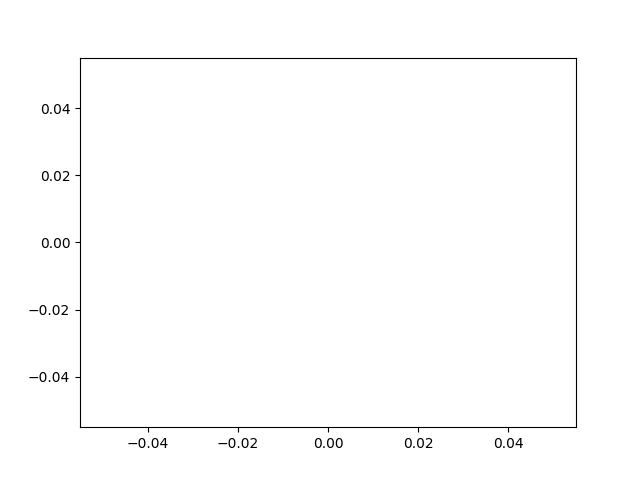

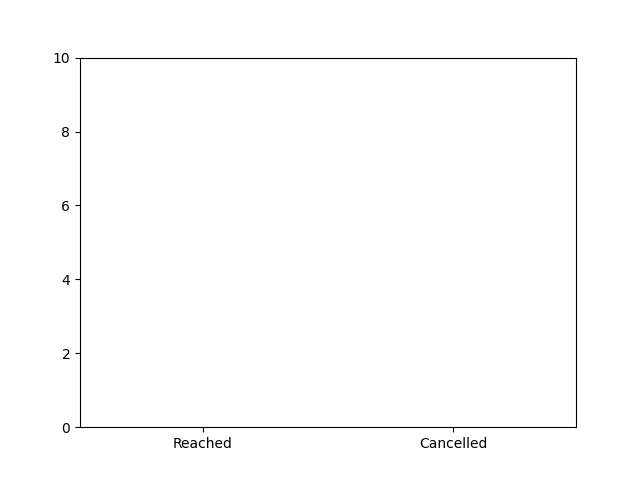

The goal has been cancelled
The goal has been cancelled


In [3]:
class RobotController:
    
    def __init__(self):
        rospy.init_node('robot_controller')
        self.vis = Visualiser()
        self.vis.start_rt_animation()
        self.pub = rospy.Publisher("/PoseVelocity", PoseVelocity, queue_size=10)
        rospy.Subscriber("/odom", Odometry, self.vis.odom_callback)
        self.action_client = actionlib.SimpleActionClient("/reaching_goal", PlanningAction)
        self.action_client.wait_for_server()

        # Widgets stuff
        self.xy_input = widgets.Text(description="Enter a goal x and y:")
        self.send_goal_button = widgets.Button(description="Send Goal")
        self.cancel_goal_button = widgets.Button(description="Cancel Goal")
        self.cancel_goal_button.layout.visibility = 'hidden'

        display(self.xy_input)
        display(self.send_goal_button)
        display(self.cancel_goal_button)

        self.send_goal_button.on_click(self.on_submit)
        self.cancel_goal_button.on_click(self.on_cancel)
        
        self.reached = 0
        self.cancelled = 0
        
        # Create a bar chart
        self.fig, self.ax = plt.subplots()
        self.ax.set_ylim(0, 10)
        self.reached_bars = self.ax.bar(['Reached', 'Cancelled'], [self.reached, self.cancelled])



    def on_submit(self, _):
        x, y = map(float, self.xy_input.value.split(','))  # input x, y (eg: 1, 2)

        self.send_goal_button.layout.visibility = 'hidden'
        self.cancel_goal_button.layout.visibility = 'visible'

        goal = PlanningGoal()
        goal.target_pose.pose.position.x = x
        goal.target_pose.pose.position.y = y

        self.action_client.send_goal(goal, done_cb=self.on_done)

    def on_cancel(self, _):
        self.action_client.cancel_goal()
        print("The goal has been cancelled")
        self.send_goal_button.layout.visibility = 'visible'
        self.cancel_goal_button.layout.visibility = 'hidden'
    
    def on_done(self, state, result):
        if state == actionlib.GoalStatus.PREEMPTED:
            print("The goal has been cancelled")
            self.cancelled += 1

        if state == actionlib.GoalStatus.SUCCEEDED:
            print("The goal has been reached")
            self.reached += 1
        
        self.send_goal_button.layout.visibility = 'visible'
        self.cancel_goal_button.layout.visibility = 'hidden'
        
         # Update the bar chart
        for i, bar in enumerate(self.reached_bars):
            bar.set_height([self.reached, self.cancelled][i])

        self.fig.canvas.draw_idle()

    def main(self):
        while not rospy.is_shutdown():
            rospy.spin()

if __name__ == '__main__':
    rc = RobotController()
    thread = Thread(target=rc.main)
    thread.start()
